## This notebook is designed to pratice with both geopandas and census data.  This is a simple spatial exploratory analysis of census data. The goal is to assess whether the location of the [linkNYC](https://www.link.nyc/) access points is optimal to guarantee a more "democratic" access to the internet.

## THE CENSUS: 
make sure you do the assigned reading about the census. Census data are a national trasure! The census is a survey  designed to collect data on every person that lives in the USA every 10 years. The Census Bureau collects data, designes aggregation areas (the census blocks and tracts for example, which are designed for maximal homogeneity across all features). However, the Census Bureau does not only collect and aggregate data every 10 years, it also collects the America Community Survey every 5 years, and some more restricted survey on an annual bases. The 1 year survey data is what we will use: https://www.census.gov/services/index.html


# 1. PUMA : Public Use Microdata Area
Census geographies that are not specific political entities (i.e. states, counties etc) are designed for homogeneity so that aggregating the data over the whole area will leat to an estimat (mean or median for example) with minimal variance. Among these geographies are the _census tracts_, _census blocks_, and _Public Use Microdata Areas (PUMAs)_. PUMAs are geographical areas designed to aggregate census data. Each PUMA contains at least 100,000 people. PUMAs do not overlap, and are contained within a single state. 

## 1.1 download the NYC  Public Use Microdata Areas (PUMA) geometry fron the NYC Open Data API and read it in with geopandas

https://data.cityofnewyork.us/Housing-Development/Public-Use-Microdata-Areas-PUMA-/cwiz-gcty/data

download it as a shape file. When you download a shapefile you actually download a zipped folder which contains the shape file and other files that are necessary to read the shape file in. You can do that with the urllib library in python 3 with the function 

        urllib.request.urlretrieve(url, "file.gz")

then unpack the data into your PUIdata directory, then read it in with geopandas, reading in the shape file with the function 

        geopandas.GeoDataFrame.from_file(filename)

PUMAs were first created for the 1990 Census. PUMAs are identified by a specific 4 numbers id. In the shapefile foung at data.cityofnewyork.us the id is named "puma" and it is in fact a 4 digits number. You can read it in as an integer (although of course it is a categorical variable inherently!). Often the PUMA id is found in conjunction with the 3 numbers state id, leading to a 7 numbers identification. The id for the State of NY is 036. See this link for more: https://www.census.gov/geo/reference/geoidentifiers.html


In [1]:
#importing all relevant packages at the first line of code: 

import os
import shutil
import urllib.request
import geopandas as gpd
import json
import requests
import io
import pandas as pd
import shapely
import pysal as ps
from fiona.crs import from_epsg
from shapely.geometry import LineString, Point
from geopandas.tools import sjoin
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# setting up the PUIDATA path
os.environ["PUIDATA"] = "%s/001_PUI/PUIDATA"%os.getenv("HOME")
print("Path to PUIDATA", os.getenv("PUIDATA"))

Path to PUIDATA /nfshome/qg412/001_PUI/PUIDATA


In [3]:
#downloading the data online using urllib
url = 'https://data.cityofnewyork.us/api/geospatial/cwiz-gcty?method=export&format=Shapefile'

urllib.request.urlretrieve(url, "pumashp")

('pumashp', <http.client.HTTPMessage at 0x7fd45441b8d0>)

In [4]:
# unzipping the file and saving it into a folder named puma
os.system("unzip " "pumashp" + " -d " + os.getenv('PUIDATA') + "/puma")

0

In [5]:
# renaming the files to a standardized name
for filename in os.listdir(os.getenv('PUIDATA') + "/puma"):
    if filename.endswith(".shp"):
        os.rename(os.getenv('PUIDATA') + "/puma/" + filename, os.getenv('PUIDATA') + "/puma/" + "puma.shp")
    if filename.endswith(".dbf"):
        os.rename(os.getenv('PUIDATA') + "/puma/" + filename, os.getenv('PUIDATA') + "/puma/" + "puma.dbf")
    if filename.endswith(".prj"):
        os.rename(os.getenv('PUIDATA') + "/puma/" + filename, os.getenv('PUIDATA') + "/puma/" + "puma.prj")
    if filename.endswith(".shx"):
        os.rename(os.getenv('PUIDATA') + "/puma/" + filename, os.getenv('PUIDATA') + "/puma/" + "puma.shx")

In [6]:
# reading and saving the shapefile using a geodataframe
pumashp = gpd.GeoDataFrame.from_file(os.getenv("PUIDATA") + "/puma/" +'puma.shp')

In [7]:
#reading the shapefile
pumashp.head()

,puma,shape_area,shape_leng,geometry
0,3701,9.792852e+07,53227.144461,POLYGON ((-73.89641133483133 40.90450452082026...
1,3702,1.889860e+08,106050.002302,"POLYGON ((-73.8442314689986 40.86942035096838,..."
2,3703,2.670137e+08,304071.257466,(POLYGON ((-73.78833349834532 40.8346671297593...
3,3704,1.062129e+08,47970.901277,"POLYGON ((-73.84792614069238 40.8713422330779,..."
4,4015,8.105438e+07,50007.415493,POLYGON ((-73.95374853778468 40.63858633758547...


In [8]:
#tells you the coordinate reference system for the shapefile
pumashp.crs

{'init': 'epsg:4326'}

In [9]:
pumashp.dtypes

puma           object
shape_area    float64
shape_leng    float64
geometry       object
dtype: object

In [10]:
pumashp['puma'] = pumashp['puma'].astype(int)

pumashp.dtypes

puma            int64
shape_area    float64
shape_leng    float64
geometry       object
dtype: object

## 1.2  plot the PUMA NYC regions

you can use the geopandas function plot. 
What is the appropriate plot to just show the shape of the PUMA regions? A choropleth could be ok, but it is better to just draw the contours of the region, since we do not want to highlight some regions over others by color choices. 

(Note: a while ago I wrote a quick function that plots choropleths and maps of NYC specifically putting legends and colorbars in the empty spaces taking advantage of the shape of the city and you are welcome to use it: https://github.com/fedhere/choroplethNYC. BUT YOU DO NOT HAVE TO)

If you want to learn how to install a package from within the notebook look here https://jakevdp.github.io/blog/2017/12/05/installing-python-packages-from-jupyter/

Your map should look someting like:

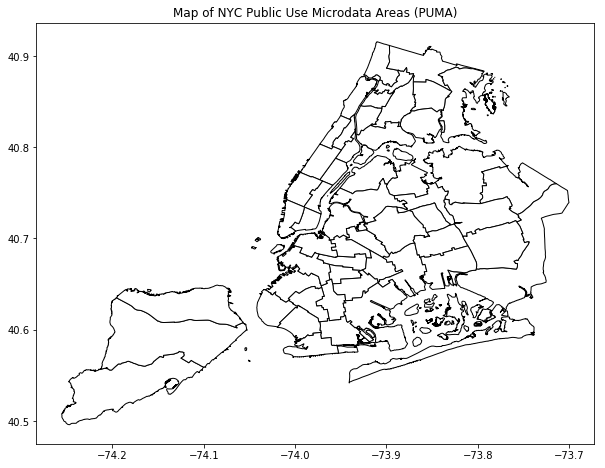

In [11]:
pumashp.plot(color='white', edgecolor="black", figsize=(10,10))
plt.title("Map of NYC Public Use Microdata Areas (PUMA)");

**Figure 1: Map of NYC Public Use Microdata Areas (PUMA). This map just shows the outline of NYC spilt into various smaller geographical boundaries for aggregating census data. **

# 2. American Fact Finder data on percentage of houses with broadband internet access

Download the table of data from 2016 for NYC: you want to obtain data on broadband access (percentage of households with broadband access) at the PUMA (Public Use Microdata Area) geographical area level. 

This may be tricky. But familiarizing with Census and American Commjunity Survey data is super important for urban science. Here you should use the API, but you should also practice interacting with the website: 

You  should read the datta in thgouth the API but also download the data manually and compare the two datasets.

## 2.1 Get data with American Fact Finder (AFF) API: 
you can request an API key, although I think it is not necessary for this search (but it is good to practice). Obtain a key and save it into a python file. DO NOT UPLOAD THE FILE CONTAINING THE API KEY TO GITHUB. Keep your API keys private. 

In [12]:
#reading in my api key saved in censusAPI.py as
#myAPI = 'XXXXXXXXXXXXXXX'
#from censusAPI import myAPI

If you need help with the API you can ask questions in this [Gitter channel](https://gitter.im/uscensusbureau/general) (I did myself to design this homework!) 
The internet subscription by household is data surveyd annually. You can find out what are the features that you can query through the API for the annually surveyed data at this url: https://api.census.gov/data/2016/acs/acs1/variables.json

read it in as a json file - you can do it with pandas (but it is slow). You can do it as I do below with the request package

In [13]:
#read in in the variables available. the info you need is in the 1year ACS data
url = "https://api.census.gov/data/2016/acs/acs1/variables.json"
resp = requests.request('GET', url)
aff1y = json.loads(resp.text)

In [14]:
#turning things into arrays to enable broadcasting
#Python3
affkeys = np.array(list(aff1y['variables'].keys()))
#Python2
#affkeys = np.array(aff1y['variables'].keys())

You need two features: **total number of households**, and **number of households with broadband access**

Broadband access is one of the B28002 keys. However there are many of those! Each variable has several observations associated to it: B28002 is all internet access data (broadband, dial up, none, ...), and for each of those you have the estimate (count, mean, median, percentage...), the margin of errors, and annotations. Those are identified by an appendix that begins with "\_". Look carefully at the line of code below and its output. I am creating a list that contains the keys of the dictionary I created from the json file for all B28002 observations  (rows that start with "B28002") that include the word "Broadband" in the description.

The syntax is a lost comprehension:

        as = \[a for a in listOfAs\] 

is simply a compact way to write

        as = \[\]
        for a in listOfAs:
            as.append(a)
            
with an if statement tha selects broadband         

In [15]:
#extracting variables of B28002 that contain "broadband"
[(k, aff1y['variables'][k]['label'])  for k in affkeys if k.startswith ("B28002") and 
 'Broadband' in aff1y['variables'][k]['label']]

[('B28002_004E',
  'Estimate!!Total!!With an Internet subscription!!Broadband of any type'),
 ('B28002_007E',
  'Estimate!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL'),
 ('B28002_008E',
  'Estimate!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL!!Broadband such as cable, fiber optic or DSL with no other type of Internet subscription')]

chose the appropriate variable and extract the relevant data: below I select the variable containing the number of household per PUMA. The "all" variable, which tells you what is the total number of units queried (households here) is generally stored in the \_001 variable (B28002_001 in this case). "E" stands for *estimate*. M stands for *margin of error*, EA *estimate annotations*, MA *margin of error annotations*. You want the estimate for this exercise. 

In [16]:
#keyword for the number of households
keyNhouseholds = 'B28002_001E'
aff1y['variables'][keyNhouseholds]

{'attributes': 'B28002_001M,B28002_001EA',
 'concept': 'PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD',
 'group': 'B28002',
 'label': 'Estimate!!Total',
 'limit': 0,
 'predicateType': 'int'}

Similarly, choose the fractions of houses with any "With an Internet subscription!!Broadband of any type"

In [17]:
#keyword for the number of households with broarband access
keyNBB = 'B28002_004E'
aff1y['variables'][keyNBB]

{'attributes': 'B28002_004M,B28002_004EA',
 'concept': 'PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD',
 'group': 'B28002',
 'label': 'Estimate!!Total!!With an Internet subscription!!Broadband of any type',
 'limit': 0,
 'predicateType': 'int'}

Now that you have the variable names use them to extract the relevant data with the ACS API. 

The API url is as follows:

root: https://api.census.gov/data/2016/acs/acs1

action: get=\[variable Name\],NAME

geometry: for=\[geometry\]:\[desired geometry values\]in=\[larger geometry\]:\[desired larger geometry values\]

API key: key:\[api key\]

the URL is constructed as root?action&geometry&key

Note that it took me a long time to figure out how to request the right geometry: in the url I write below the geometry is "public%20use%20microdata%20area" where %20 is the character for ' ' (space) in a url, and ":\*" means all PUMAS

state:36 is New York State

In [18]:
# getting the broadband access number of households
url = "https://api.census.gov/data/2016/acs/acs1?get=" + keyNBB +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36"
resp = requests.request('GET', url).content
pumaBB = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))

pumaBB.head()

,B28002_004E,NAME,state,public use microdata area,Unnamed: 4
0,32607,"St. Lawrence County PUMA, New York",36,100,NaN
1,50811,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,41210,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,36075,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,47786,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


In [19]:
#getting the first row of the table: the total number of households
url = "https://api.census.gov/data/2016/acs/acs1?get=" + keyNhouseholds +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36"
resp = requests.request('GET', url).content
pumaPP = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))

pumaPP.head(1)

,B28002_001E,NAME,state,public use microdata area,Unnamed: 4
0,40479,"St. Lawrence County PUMA, New York",36,100,NaN


## 2.2 generate a feature for the percentage of households with broadband access

In [20]:
pumaBB.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145 entries, 0 to 144
Data columns (total 5 columns):
B28002_004E                  145 non-null int64
NAME                         145 non-null object
state                        145 non-null int64
public use microdata area    145 non-null int64
Unnamed: 4                   0 non-null float64
dtypes: float64(1), int64(3), object(1)
memory usage: 5.7+ KB


In [21]:
pumaBB['NAME'] = pumaBB['NAME'].astype(str)
pumaPP['NAME'] = pumaBB['NAME'].astype(str)

In [22]:
merged = pd.merge(pumaBB, pumaPP, on="NAME")
merged.head()

,B28002_004E,NAME,state_x,public use microdata area_x,Unnamed: 4_x,B28002_001E,state_y,public use microdata area_y,Unnamed: 4_y
0,32607,"St. Lawrence County PUMA, New York",36,100,NaN,40479,36,100,NaN
1,50811,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN,67092,36,200,NaN
2,41210,"Warren & Washington Counties PUMA, New York",36,300,NaN,51614,36,300,NaN
3,36075,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN,44300,36,401,NaN
4,47786,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN,61146,36,402,NaN


In [23]:
#percentage of households with broadband access
merged['percentage'] = merged['B28002_004E'] / merged['B28002_001E'] * 100
merged.head()

,B28002_004E,NAME,state_x,public use microdata area_x,Unnamed: 4_x,B28002_001E,state_y,public use microdata area_y,Unnamed: 4_y,percentage
0,32607,"St. Lawrence County PUMA, New York",36,100,NaN,40479,36,100,NaN,80.552879
1,50811,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN,67092,36,200,NaN,75.733321
2,41210,"Warren & Washington Counties PUMA, New York",36,300,NaN,51614,36,300,NaN,79.842678
3,36075,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN,44300,36,401,NaN,81.433409
4,47786,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN,61146,36,402,NaN,78.150656


In [24]:
merged.columns

Index(['B28002_004E', 'NAME', 'state_x', 'public use microdata area_x',
       'Unnamed: 4_x', 'B28002_001E', 'state_y', 'public use microdata area_y',
       'Unnamed: 4_y', 'percentage'],
      dtype='object')

In [25]:
merged.drop(['state_x','Unnamed: 4_x', 'public use microdata area_y', 'Unnamed: 4_y'],axis=1, inplace=True)

In [26]:
merged.head()

,B28002_004E,NAME,public use microdata area_x,B28002_001E,state_y,percentage
0,32607,"St. Lawrence County PUMA, New York",100,40479,36,80.552879
1,50811,"Clinton, Franklin, Essex & Hamilton Counties P...",200,67092,36,75.733321
2,41210,"Warren & Washington Counties PUMA, New York",300,51614,36,79.842678
3,36075,Herkimer (North & Central) & Oneida (Outer) Co...,401,44300,36,81.433409
4,47786,Oneida County (Central)--Greater Utica & Rome ...,402,61146,36,78.150656


## 2.3 Now compare it with the AFF published "percentage of households with broadband access" which is a feature available through their website but that cannot be downloaded directly from the API. It compiled by AFF the same way we did above

Manually you can download the GCT Geographic Comparison Tables. Download the GCT table that contains the percentage of households in each PUMA with broadband internet subscription as follows:

https://factfinder.census.gov/ -> Advanced Search -> Show me all 

    - Topics: Product Type -> Geography Comparison Table 
    
select the PERCENT OF HOUSEHOLDS WITH A BROADBAND INTERNET SUBSCRIPTION  at our geography granularity (PUMA) and click Download below. This will generate the table on the fly and you can click again on Download.

Move the file into the PUIdata directory, unzip it and load it with pandas.
    
Your table shold be labeled as: GCT2801	

One more hurdle: you need to move this data to jupyterhub/compute, and the link is not something you can copy and paste!
Two solutions:

-easier but less preferible: upload the table you downloaded locally to github AWS, or else where, and download it from compute

-otherwise, learn how to do it with sftp from your local terminal: these are the steps

1. ON YOUR LOCAL MACHINE where you downloaded the table (which was downloaded as aff_download.zip for me in my ~/Downloads folder) type the following *sftp* command
        
        fbianco@Federicas-MacBook-Air:~$ sftp fbianco@staging.cusp.nyu.edu
    
2. Input your password
            
        Password: 
        Connected to staging.cusp.nyu.edu.

   This should open an sftp promopt (you should see sftp> at the beginning of the line). Go to the PUI directory (for me /home/fbianco/PUIdata)
    
        sftp> cd /home/fbianco/PUIdata             
        
3. Use the sftp command _put_ to copy the file from the local to the remote machine to compute, making sure you use the full path (unless the file was downloaded in your local directory in the local machine)
    
        sftp> put /Users/fbianco/Downloads/aff_download.zip
        
You should see:

            Uploading /Users/fbianco/Downloads/aff_download.zip to ....

And the file can be unzipped and read into your code with pandas. I leave the read in line below for your convenience, those are the only variables you need.

In [27]:
bbpc = pd.read_csv(os.getenv("PUIDATA") + "/ACS_16_1YR_GCT2801.ST50_with_ann.csv",
            usecols=["GCT_STUB.target-geo-id2","HC01","HC02"])

bbpc.head()

,GCT_STUB.target-geo-id2,HC01,HC02
0,Target Geo Id2,Percent,Margin of Error
1,01,74.7,0.5
2,0100100,70.9,2.5
3,0100200,80.5,2.7
4,0100301,87.0,2.8


notice 2 things:
    - that the Target Geo Id2: GCT_STUB.target-geo-id2 is a 7 digits number. See my comment above about it. 
    - that there is a weird double header. You can deal with it in one of 2 ways: either reread the file in skipping one row and using the second row as header, or remove that row (for example with bbpc.drop(0, inplace=True)) but also then you should check the *type* of your GCT_STUB.target-geo-id2 feature! The fact that pandas had to read in a column with nombers and characters forced it to read it as a string, and you need to convert it (.astype(int)) to merge it easily with the API acquired data.
    
In the API dataframe the PUMA id was a 4 digit number. If you have them both as integers and you remove the initial three digits (for example by subtracting 360000 from each value wich you can do as bbpc["gid"] = bbpc.gid - 3600000 then you can merge on the puma id 

In [28]:
# dropping the additional column

bbpc.drop(0, inplace=True)

bbpc.head()

,GCT_STUB.target-geo-id2,HC01,HC02
1,01,74.7,0.5
2,0100100,70.9,2.5
3,0100200,80.5,2.7
4,0100301,87.0,2.8
5,0100302,81.9,2.9


In [29]:
# finding out the data types using the dtypes command
bbpc.dtypes

GCT_STUB.target-geo-id2    object
HC01                       object
HC02                       object
dtype: object

In [30]:
# convert the GCT column into integer
bbpc['GCT_STUB.target-geo-id2'] = bbpc['GCT_STUB.target-geo-id2'].astype(int)
bbpc.dtypes

GCT_STUB.target-geo-id2     int64
HC01                       object
HC02                       object
dtype: object

In [31]:
#creating a gid column, though i am not sure if this is the correct version. 
bbpc["gid"] = bbpc['GCT_STUB.target-geo-id2'] - 3600000
bbpc.head()

,GCT_STUB.target-geo-id2,HC01,HC02,gid
1,1,74.7,0.5,-3599999
2,100100,70.9,2.5,-3499900
3,100200,80.5,2.7,-3499800
4,100301,87.0,2.8,-3499699
5,100302,81.9,2.9,-3499698


## check that the percentage of households with broadband you generated and the one you red in from the table you downloaded manually are the same

Personal notes: First up what the heck is gid: a unique id. What is the code below trying to do? 

1) we need to do gid column first in the imported csv
2) then we need to merge it with the merged dataframe created earlier, 
3) we are basically joining merged datafram with the new csv based on public use microdata, adding new information gid

In [32]:
bbpc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2430 entries, 1 to 2430
Data columns (total 4 columns):
GCT_STUB.target-geo-id2    2430 non-null int64
HC01                       2430 non-null object
HC02                       2430 non-null object
gid                        2430 non-null int64
dtypes: int64(2), object(2)
memory usage: 94.9+ KB


In [33]:
bbpc['HC01'] = bbpc['HC01'].astype(float)
bbpc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2430 entries, 1 to 2430
Data columns (total 4 columns):
GCT_STUB.target-geo-id2    2430 non-null int64
HC01                       2430 non-null float64
HC02                       2430 non-null object
gid                        2430 non-null int64
dtypes: float64(1), int64(2), object(1)
memory usage: 94.9+ KB


In [34]:
diff_ = merged.merge(bbpc, left_on="public use microdata area_x", right_on="gid")[["percentage", "HC01"]]

diff_["diff"] = np.abs(diff_["percentage"] - diff_["HC01"].astype(float))

diff_.describe()

,percentage,HC01,diff
count,145.000000,145.000000,145.000000
mean,81.845478,81.843448,0.026217
std,7.063369,7.065358,0.014480
min,54.932945,54.900000,0.000178
25%,77.770257,77.800000,0.012252
50%,82.826141,82.800000,0.027230
75%,87.305077,87.300000,0.039090
max,93.404143,93.400000,0.049872


the maximum difference should only be a few percent.

# 3 Plot a choropleth of NYC broadband access 
## 3.1 Merge with the puma geodataframe and plot a choropleth of the percentage of households with broadband access

In [35]:
# performing a table join of the bbpc table to shapefile (pumashp)
# so that the shapefile can now display the information graphically
pumashp = pumashp.merge(bbpc, left_on='puma', right_on='gid')
pumashp.head() 

,puma,shape_area,shape_leng,geometry,GCT_STUB.target-geo-id2,HC01,HC02,gid
0,3701,9.792852e+07,53227.144461,POLYGON ((-73.89641133483133 40.90450452082026...,3603701,84.3,2.6,3701
1,3702,1.889860e+08,106050.002302,"POLYGON ((-73.8442314689986 40.86942035096838,...",3603702,68.3,3.7,3702
2,3703,2.670137e+08,304071.257466,(POLYGON ((-73.78833349834532 40.8346671297593...,3603703,82.8,3.2,3703
3,3704,1.062129e+08,47970.901277,"POLYGON ((-73.84792614069238 40.8713422330779,...",3603704,72.6,3.6,3704
4,4015,8.105438e+07,50007.415493,POLYGON ((-73.95374853778468 40.63858633758547...,3604015,78.8,2.9,4015


Text(0.5,1,'Percentage of household with broadband access')

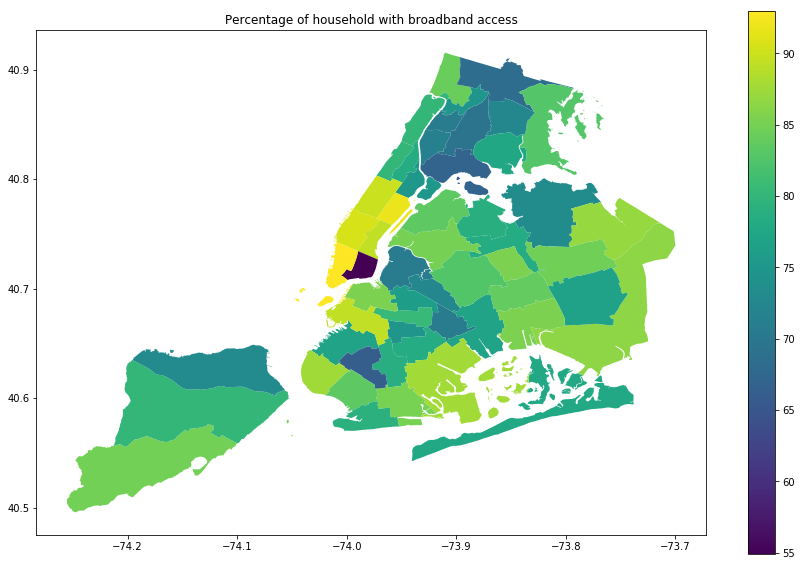

In [77]:
ax = pumashp.plot(figsize=(15,10), column='HC01', legend=True)
plt.title("Percentage of household with broadband access")

**Figure 2: Map of percentage of household with broadband access in NYC as per Public Use Microdata Areas (PUMA). Lower Manhatten has one of the highest percentage of household with broadband access, while Bronx have a high concentration households with without broadband access. **  

# 4. LinkNYC: assess whether the locations of the linkNYC stations are supplying internet where it is needed.

acquire the linkNYC locations and prepare them into a dataframe
read it in from the HW9_fb55 folder in :
https://github.com/fedhere/PUI2017_fb55

Notice that you can also get a linkNYC locations shapefile from NYC open data, as I did to generate this, but I want you do to do some extra coordinates gymnastics for practice so use the one I provide.

In [38]:
#download the location files
os.system("wget https://raw.githubusercontent.com/fedhere/PUI2018_fb55/master/HW7_fb55/linkNYClocations.csv")

0

In [39]:
#move it to PUIDATA
shutil.move("linkNYClocations.csv", os.getenv("PUIDATA"))

'/nfshome/qg412/001_PUI/PUIDATA/linkNYClocations.csv'

In [40]:
# reading the csv file 
linkNYC = pd.read_csv(os.getenv("PUIDATA") + "/linkNYClocations.csv")

In [41]:
linkNYC.head()

,Unnamed: 0,link_site,longitude,date_link_,latitude
0,0,bk-01-138951,-73.942489,2017-07-01,40.701668
1,1,bk-01-109091,-73.942169,2017-07-01,40.701542
2,2,bk-01-143982,-73.942239,2017-07-01,40.701930
3,3,bk-01-109262,-73.942918,2017-04-28,40.705060
4,4,bk-01-125268,-73.953439,2017-03-31,40.728133


In [42]:
linkNYC.shape

(1414, 5)

## combine long lat into a column like you did in the lab to greate a "geometry" column for the dataframe, then convert the dataframe into a GeoDataFrame _linkNYC_ and set native coordinates  frame to lat/lon as you did in the lab
    linkNYC.crs = ...

In [43]:
# combine lat long to create a geometry column in a dataframe
linkNYC['lonlat']=list(zip(linkNYC.longitude,linkNYC.latitude))
linkNYC.head()

,Unnamed: 0,link_site,longitude,date_link_,latitude,lonlat
0,0,bk-01-138951,-73.942489,2017-07-01,40.701668,"(-73.94248859, 40.70166753)"
1,1,bk-01-109091,-73.942169,2017-07-01,40.701542,"(-73.9421692831, 40.7015421938)"
2,2,bk-01-143982,-73.942239,2017-07-01,40.701930,"(-73.9422392385, 40.7019303439)"
3,3,bk-01-109262,-73.942918,2017-04-28,40.705060,"(-73.94291758, 40.70506042)"
4,4,bk-01-125268,-73.953439,2017-03-31,40.728133,"(-73.953439, 40.728133)"


In [44]:
# create a geodataframe from the dataframe
linkNYC = gpd.GeoDataFrame(linkNYC)
linkNYC.head()

,Unnamed: 0,link_site,longitude,date_link_,latitude,lonlat
0,0,bk-01-138951,-73.942489,2017-07-01,40.701668,"(-73.94248859, 40.70166753)"
1,1,bk-01-109091,-73.942169,2017-07-01,40.701542,"(-73.9421692831, 40.7015421938)"
2,2,bk-01-143982,-73.942239,2017-07-01,40.701930,"(-73.9422392385, 40.7019303439)"
3,3,bk-01-109262,-73.942918,2017-04-28,40.705060,"(-73.94291758, 40.70506042)"
4,4,bk-01-125268,-73.953439,2017-03-31,40.728133,"(-73.953439, 40.728133)"


In [45]:
# set native coordinates frame 
linkNYC.crs = from_epsg(4326)
linkNYC.crs

{'init': 'epsg:4326', 'no_defs': True}

# plot the location of the linkNYC stations on top of a choropleth of broadband access percentage in *5 equal intervals*

I have also color coded the station by how long ago they have been installed, using the date datetime variable

In [46]:
linkNYC['geometry'] = linkNYC[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
linkNYC.head()

,Unnamed: 0,link_site,longitude,date_link_,latitude,lonlat,geometry
0,0,bk-01-138951,-73.942489,2017-07-01,40.701668,"(-73.94248859, 40.70166753)",POINT (-73.94248859 40.70166753)
1,1,bk-01-109091,-73.942169,2017-07-01,40.701542,"(-73.9421692831, 40.7015421938)",POINT (-73.9421692831 40.7015421938)
2,2,bk-01-143982,-73.942239,2017-07-01,40.701930,"(-73.9422392385, 40.7019303439)",POINT (-73.94223923850001 40.7019303439)
3,3,bk-01-109262,-73.942918,2017-04-28,40.705060,"(-73.94291758, 40.70506042)",POINT (-73.94291758 40.70506042)
4,4,bk-01-125268,-73.953439,2017-03-31,40.728133,"(-73.953439, 40.728133)",POINT (-73.953439 40.728133)


In [47]:
# converting date link into the datetime format
linkNYC['date'] = pd.to_datetime(linkNYC['date_link_'])
#dropping the time portion and keeping only the date, else the map can't display the points when it has the time portion
linkNYC['date_only'] = linkNYC['date'].apply(lambda x: x.date())  
linkNYC.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1414 entries, 0 to 1413
Data columns (total 9 columns):
Unnamed: 0    1414 non-null int64
link_site     1414 non-null object
longitude     1414 non-null float64
date_link_    1414 non-null object
latitude      1414 non-null float64
lonlat        1414 non-null object
geometry      1414 non-null object
date          1414 non-null datetime64[ns]
date_only     1414 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 99.5+ KB


# Question to tutor: Even though date_only is displayed as "object" here, it can  still be displayed on the map later. Does that mean this is a bug as it is still a datetime type?

In [48]:
linkNYC.head()

,Unnamed: 0,link_site,longitude,date_link_,latitude,lonlat,geometry,date,date_only
0,0,bk-01-138951,-73.942489,2017-07-01,40.701668,"(-73.94248859, 40.70166753)",POINT (-73.94248859 40.70166753),2017-07-01,2017-07-01
1,1,bk-01-109091,-73.942169,2017-07-01,40.701542,"(-73.9421692831, 40.7015421938)",POINT (-73.9421692831 40.7015421938),2017-07-01,2017-07-01
2,2,bk-01-143982,-73.942239,2017-07-01,40.701930,"(-73.9422392385, 40.7019303439)",POINT (-73.94223923850001 40.7019303439),2017-07-01,2017-07-01
3,3,bk-01-109262,-73.942918,2017-04-28,40.705060,"(-73.94291758, 40.70506042)",POINT (-73.94291758 40.70506042),2017-04-28,2017-04-28
4,4,bk-01-125268,-73.953439,2017-03-31,40.728133,"(-73.953439, 40.728133)",POINT (-73.953439 40.728133),2017-03-31,2017-03-31


In [49]:
# cleaning the linkNYC dataset
linkNYC.drop(['Unnamed: 0', 'date_link_', 'date', 'lonlat'], axis=1, inplace=True)
linkNYC.head()

,link_site,longitude,latitude,geometry,date_only
0,bk-01-138951,-73.942489,40.701668,POINT (-73.94248859 40.70166753),2017-07-01
1,bk-01-109091,-73.942169,40.701542,POINT (-73.9421692831 40.7015421938),2017-07-01
2,bk-01-143982,-73.942239,40.701930,POINT (-73.94223923850001 40.7019303439),2017-07-01
3,bk-01-109262,-73.942918,40.705060,POINT (-73.94291758 40.70506042),2017-04-28
4,bk-01-125268,-73.953439,40.728133,POINT (-73.953439 40.728133),2017-03-31


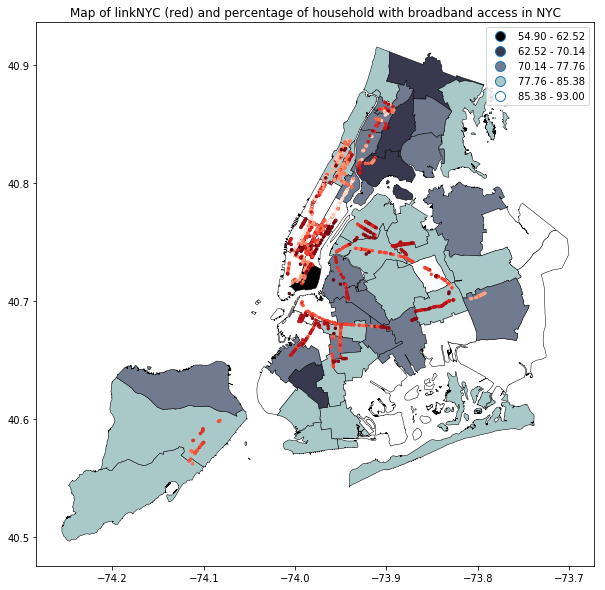

In [50]:
# code credit @http://jose-coto.com/plotting-geopandas &
# https://matplotlib.org/users/colormaps.html for the colour scheme of the basemap
f, ax = plt.subplots(figsize=(10,10))
base = pumashp.plot(column='HC01',cmap='bone', edgecolor="black", alpha=1,
                  linewidth=0.5,ax=ax, scheme="Equal_interval", legend=True, k=5), linkNYC.plot(ax=ax, column='date_only', cmap='Reds', markersize=6, alpha=1)
ax.set_title("Map of linkNYC (red) and percentage of household with broadband access in NYC");

**Figure 3: Map of linkNYC locations (red dots) and percentage of household with broadband access in NYC as per Public Use Microdata Areas (PUMA). Each linkNYC is displayed as a point, in various intensity of red color according the date it was installed. linkNYC is most concetrated in Manhatten, which have one of the highest percentage of broadband access in new york. Meanwhile, areas in Bronx with some of the lowest percentage of broadband access do not have any linkNYC installed in the locality. **

# 5 Find the number of linkNYC locations per person by PUMA

## 5.1 with the AFF API from ACS get the total population by puma and merge it into your GeoDF

the ACS population by  variable is B00001_001E, and of course your geometry is PUMA, _public%20use%20microdata%20area:*_, as before

In [51]:
# Reading ACS population
pop = 'B00001_001E'

In [52]:
url = "https://api.census.gov/data/2016/acs/acs1?get=" + pop +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36"
resp = requests.request('GET', url).content
pumapop = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))
pumapop.head()

,B00001_001E,NAME,state,public use microdata area,Unnamed: 4
0,3075,"St. Lawrence County PUMA, New York",36,100,NaN
1,4356,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,2736,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,2722,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,2874,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


In [53]:
# cleaning pumapop
pumapop.drop(['Unnamed: 4', 'state', 'NAME'], axis=1, inplace=True)
pumapop.head(3)

,B00001_001E,public use microdata area
0,3075,100
1,4356,200
2,2736,300


## 5.2 find the number of station per 100 people per PUMA
**Important** you can do this with an sjoin(). But sjoin() should not be used with lat/lon coordinates cause they are **not "flat coordinates"**. Since spattial joins are done in cartesian geometry the only coordinate systems suitable to spatial joins are flat coordinate plane systems, which in the NYC area is 2263. So before you proceed to the sjoin you have to convert both pumashp and linkNYC to 2263 (for example with GeoDataFrame method .to_crs(epsg=...) )


(A note: You can also do this by hand by asking for each point if it is in any of the regions, for example in a for loop. But that is escruciatingly slow, unless you get smart about your requests (for example for a given PUMA not asking if the coordinates of a point are very different from the center of a PUMA). With the new version of geopandas this is not needed, cause the sjoin is fast, but with the older versions this was sometimes better) )

**Convert coordinates for pumashp and linkNYC**

In [54]:
pumapop_ft = pumashp.to_crs(epsg=2263)
linkNYC_ft = linkNYC.to_crs(epsg=2263)

pumapop_ft.crs

{'init': 'epsg:2263', 'no_defs': True}

**Create a geodataframe with a spatial join and use groupby to count the number of linkNYC in each PUMA**

In [55]:
linkpp = gpd.sjoin(linkNYC_ft, pumapop_ft).groupby('puma').count()
linkpp.head()

,link_site,longitude,latitude,geometry,date_only,index_right,shape_area,shape_leng,GCT_STUB.target-geo-id2,HC01,HC02,gid
puma,,,,,,,,,,,,
3701,1,1,1,1,1,1,1,1,1,1,1,1
3705,1,1,1,1,1,1,1,1,1,1,1,1
3706,20,20,20,20,20,20,20,20,20,20,20,20
3707,29,29,29,29,29,29,29,29,29,29,29,29
3708,19,19,19,19,19,19,19,19,19,19,19,19


In [56]:
# cleaning the linkpp dataset to display only puma and link_site count
linkpp.drop(['longitude', 'latitude', 'geometry', 'date_only', 'index_right', 'shape_area', 'shape_leng', 'GCT_STUB.target-geo-id2', 'HC01', 'HC02', 'gid'], axis=1, inplace=True)
linkpp.head()

,link_site
puma,
3701,1
3705,1
3706,20
3707,29
3708,19


**Finally merge back into the pumashp** 

Make sure you use the correct scheme for merging: you want to have _all_ the PUMAs, not only the ones that have linkNYC in them in the final geoDF

In [57]:
# previously, linkpp's index was puma, meaning I cant merge it base on puma to pumashp
# therefore, need to reset index so that puma is a column 
linkpp2 = linkpp.reset_index()
linkpp2.head()

,puma,link_site
0,3701,1
1,3705,1
2,3706,20
3,3707,29
4,3708,19


In [58]:
# using the join function because merge, concat couldn't give the desired output
pumashplc = pumashp.join(linkpp, on='puma')
pumashplc

,puma,shape_area,shape_leng,geometry,GCT_STUB.target-geo-id2,HC01,HC02,gid,link_site
0,3701,9.792852e+07,53227.144461,POLYGON ((-73.89641133483133 40.90450452082026...,3603701,84.3,2.6,3701,1.0
1,3702,1.889860e+08,106050.002302,"POLYGON ((-73.8442314689986 40.86942035096838,...",3603702,68.3,3.7,3702,NaN
2,3703,2.670137e+08,304071.257466,(POLYGON ((-73.78833349834532 40.8346671297593...,3603703,82.8,3.2,3703,NaN
3,3704,1.062129e+08,47970.901277,"POLYGON ((-73.84792614069238 40.8713422330779,...",3603704,72.6,3.6,3704,NaN
4,4015,8.105438e+07,50007.415493,POLYGON ((-73.95374853778468 40.63858633758547...,3604015,78.8,2.9,4015,3.0
5,4016,1.207135e+08,109477.751817,POLYGON ((-73.94405560932151 40.61199284173428...,3604016,85.2,1.9,4016,NaN
6,3705,1.224951e+08,68657.316149,POLYGON ((-73.87359713633828 40.83979855593596...,3603705,69.4,3.2,3705,1.0
7,3706,4.388687e+07,51799.404183,"POLYGON ((-73.88785196328796 40.8721141761279,...",3603706,74.7,3.6,3706,20.0
8,3707,4.228113e+07,37347.925798,"POLYGON ((-73.89735765412577 40.8587627349268,...",3603707,70.6,3.5,3707,29.0
9,4006,6.184965e+07,42555.996557,POLYGON ((-73.95526963654763 40.67012490485409...,3604006,80.6,2.8,4006,33.0


In [59]:
# joining the population data into pumashplc
pumashplc2 = pumashplc.merge(pumapop, left_on='puma', right_on='public use microdata area')
pumashplc2.head()

,puma,shape_area,shape_leng,geometry,GCT_STUB.target-geo-id2,HC01,HC02,gid,link_site,B00001_001E,public use microdata area
0,3701,9.792852e+07,53227.144461,POLYGON ((-73.89641133483133 40.90450452082026...,3603701,84.3,2.6,3701,1.0,1517,3701
1,3702,1.889860e+08,106050.002302,"POLYGON ((-73.8442314689986 40.86942035096838,...",3603702,68.3,3.7,3702,NaN,1959,3702
2,3703,2.670137e+08,304071.257466,(POLYGON ((-73.78833349834532 40.8346671297593...,3603703,82.8,3.2,3703,NaN,1305,3703
3,3704,1.062129e+08,47970.901277,"POLYGON ((-73.84792614069238 40.8713422330779,...",3603704,72.6,3.6,3704,NaN,1882,3704
4,4015,8.105438e+07,50007.415493,POLYGON ((-73.95374853778468 40.63858633758547...,3604015,78.8,2.9,4015,3.0,2515,4015


In [60]:
pumashplc2.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 55 entries, 0 to 54
Data columns (total 11 columns):
puma                         55 non-null int64
shape_area                   55 non-null float64
shape_leng                   55 non-null float64
geometry                     55 non-null object
GCT_STUB.target-geo-id2      55 non-null int64
HC01                         55 non-null float64
HC02                         55 non-null object
gid                          55 non-null int64
link_site                    37 non-null float64
B00001_001E                  55 non-null int64
public use microdata area    55 non-null int64
dtypes: float64(4), int64(5), object(2)
memory usage: 5.2+ KB


In [61]:
# calculating number of station per 100 people per PUMA
pumashplc2["linkNYCp100p"] = pumashplc2['link_site'] / pumashplc2['B00001_001E'] *100

In [62]:
pumashplc2["linkNYCp100p"].describe()

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/function_base.py:3403: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


count    37.000000
mean      2.327677
std       3.328955
min       0.049727
25%            NaN
50%            NaN
75%            NaN
max      15.141540
Name: linkNYCp100p, dtype: float64

# Plotting the linkNYC locations on top of a choropleth of number of stations per 100 people  in 10 equal intervals


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/function_base.py:3142: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


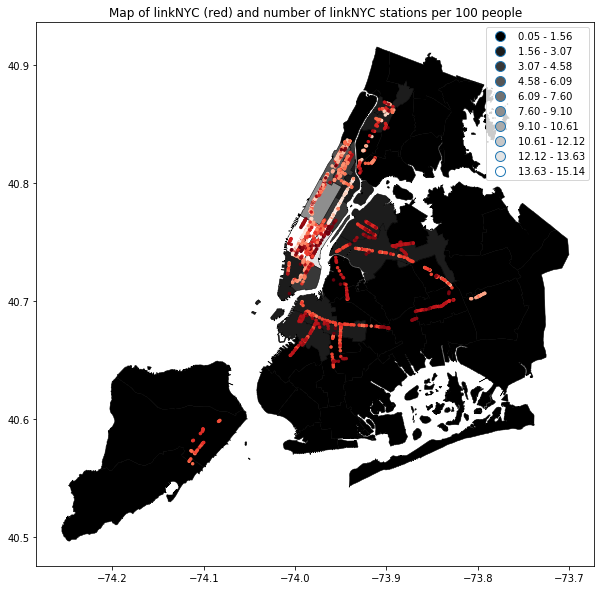

In [63]:
# learning point: each color scheme has a reverse scheme, just need to add _r to the name! 
f, ax = plt.subplots(figsize=(10,10))
base = pumashplc2.plot(column='linkNYCp100p',cmap='binary_r', edgecolor="black", alpha=1,
                  linewidth=0.5,ax=ax, scheme="Equal_interval", legend=True, k=10), linkNYC.plot(ax=ax, column='date_only', cmap='Reds', markersize=6, alpha=1)
ax.set_title("Map of linkNYC (red) and number of linkNYC stations per 100 people");

**Figure 4: Map of linkNYC stations in red ontop of a chloropeth map showing number of stations per 100 people in 10 equal intervals, as per Public Use Microdata Areas (PUMA). Lower manhattan has the highest concentration of linkNYC stations per 100 people. All other areas in new york city other than lower manhattan have very low concentration of linkNYC stations per 100 people!**

# Extra credit 1: 
How would you enhance the visibility of this map? you are working with numbers that are mostly very low, and reside near each other, and them have a few much higher value points. Notice that here the high values are interesting though and should not be thrown away!

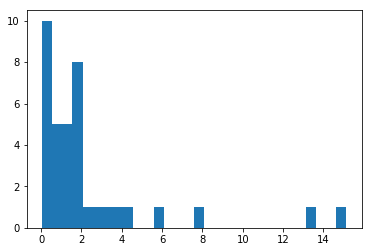

In [64]:
# dropping the NA
pumashp2 = pumashplc2.dropna(subset=['linkNYCp100p'])

plt.hist(pumashp2["linkNYCp100p"], bins=30);

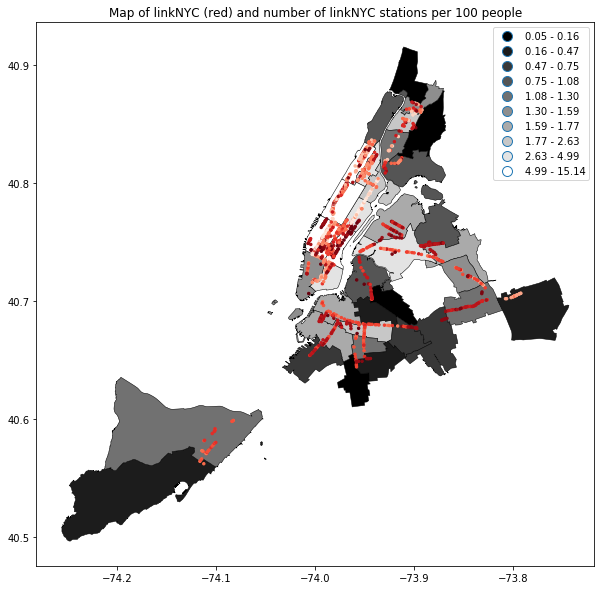

In [65]:
# Choice between Quantiles and Fisher Jenks scheme
f, ax = plt.subplots(figsize=(10,10))
base = pumashp2.plot(column='linkNYCp100p',cmap='binary_r', edgecolor="black", alpha=1,
                  linewidth=0.5,ax=ax, scheme="Quantiles", legend=True, k=10), linkNYC.plot(ax=ax, column='date_only', cmap='Reds', markersize=6, alpha=1)
ax.set_title("Map of linkNYC (red) and number of linkNYC stations per 100 people");

**Figure 5: Map of linkNYC in red ontop of a chloropeth map showing number of stations per 100 people in 10 equal intervals, as per Public Use Microdata Areas (PUMA). This map is treated by dropping and NaN values, thus no display in areas like lower Brooklyn and selecting the display of the chloropeth to be Quantiles instead, and shows more variation in the display. Mid-town manhattan has the highest concentration of linkNYC stations per 100 people,followed by areas in Queens.**

## Extra Credit 2:
plot Spatial Lag Deciles that describe the impact of linkNYC in providing access where needed. You can follow what you did in the lab, but you need to create a metric based on the data you have tha measures the impact of linkNYC


**Creating a matrix**

In [66]:
%mkdir Output

mkdir: cannot create directory ‘Output’: File exists


In [67]:
# creating a path
path='Output/pumashp2.shp'
pumashp2.to_file(path)

In [68]:
# creating a weight file, where queen refers to the neighboring cells
qW_CT=ps.queen_from_shapefile(path)

In [69]:
qW_CT[10]

{1: 1.0, 26: 1.0}

In [70]:
Wmatrix, ids = qW_CT.full()
Wmatrix

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.]])

In [71]:
qW_CT.transform = 'r'

In [72]:
linkNYCimpact = pumashp2.linkNYCp100p
linkNYCimpact_Lag = ps.lag_spatial(qW_CT, linkNYCimpact)

In [73]:
linkNYCimpactLagQ10 = ps.Quantiles(linkNYCimpact_Lag, k=10)
linkNYCimpactLagQ10

              Quantiles              
 
Lower          Upper            Count
        x[i] <= 0.672               4
0.672 < x[i] <= 0.916               4
0.916 < x[i] <= 0.974               3
0.974 < x[i] <= 1.077               4
1.077 < x[i] <= 1.280               4
1.280 < x[i] <= 1.618               3
1.618 < x[i] <= 3.122               4
3.122 < x[i] <= 4.432               3
4.432 < x[i] <= 6.176               4
6.176 < x[i] <= 9.704               4

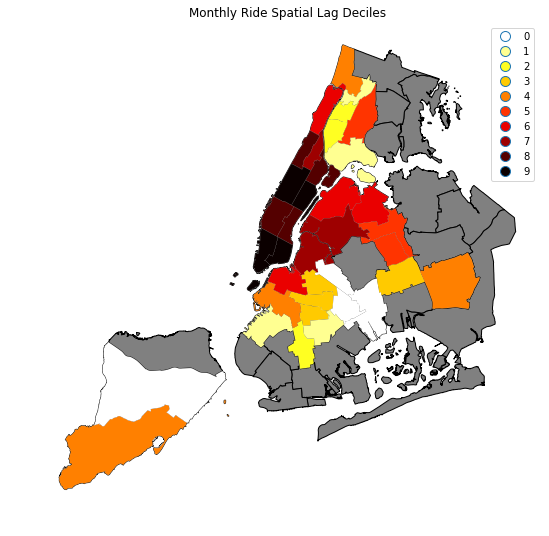

In [74]:
f, ax = plt.subplots(figsize=(9, 9))
pumashp.plot(ax=ax, color='grey', edgecolor="black", figsize=(9,9))
pumashp2.assign(cl=linkNYCimpactLagQ10.yb).plot(column='cl', categorical=True, 
        k=10, cmap='hot_r', linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Monthly Ride Spatial Lag Deciles");

**Figure 6: Map of Monthly Ride Spatial Lag Deciles according to Public Use Microdata Areas (PUMA) in New York. There is no uniform distribution of linkNYC's impact throughout all PUMAs, with lower manhattan having the highest value. For areas without NaN values, bronx has one of the highest concentration of lower values.**